Условия лабы:
Дедлайн: 11.10.2023 - 26.10.2023
Задача:  Классификация текста

3) ML секция:
   - обучить 1-2 модельки нейронок (можно самописные или готовые взять существующие архитектуры)
В этом пункте если вы решили взять 1 модель классического ML, то нужно построить 2 нейронки, а если 2 классического ML, то 1 нейронку.
ВАЖНО! Стоит заметить, если у вас задача не бинарной классификации, то стоит выводить метрики accuracy и F1 score для всех классов так же, потому что итоговым результатом вы получаешь усредненную метрику для всех классов.

За все это будет оценка 7.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import regex as re

In [2]:
tweets = pd.read_csv('/content/tweets.csv')

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [4]:
tweets

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


### EDA

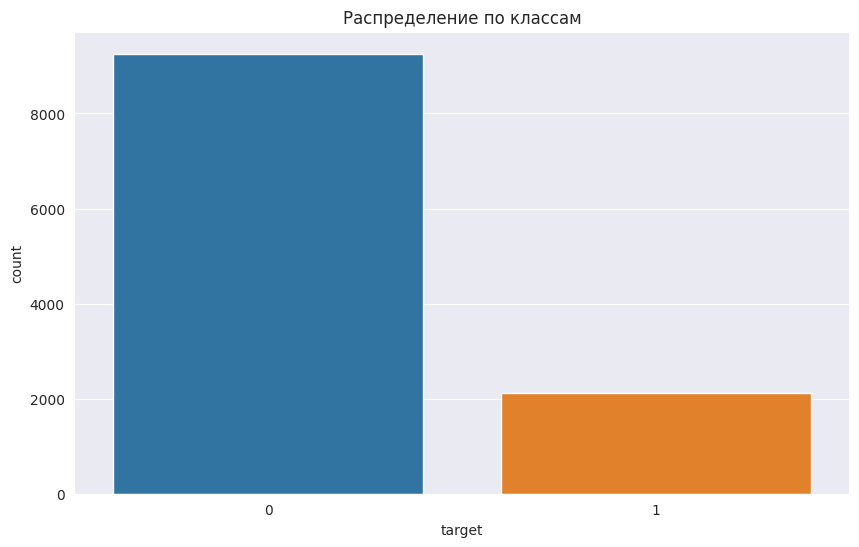

In [5]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(data=tweets, x='target')
plt.title('Распределение по классам')
plt.show()

Чаще встречаются твиты, не имеющие в себе информацию о какой-либо катастрофе. Disaster twits составляют около 20% от общего числа твитов в датасете.

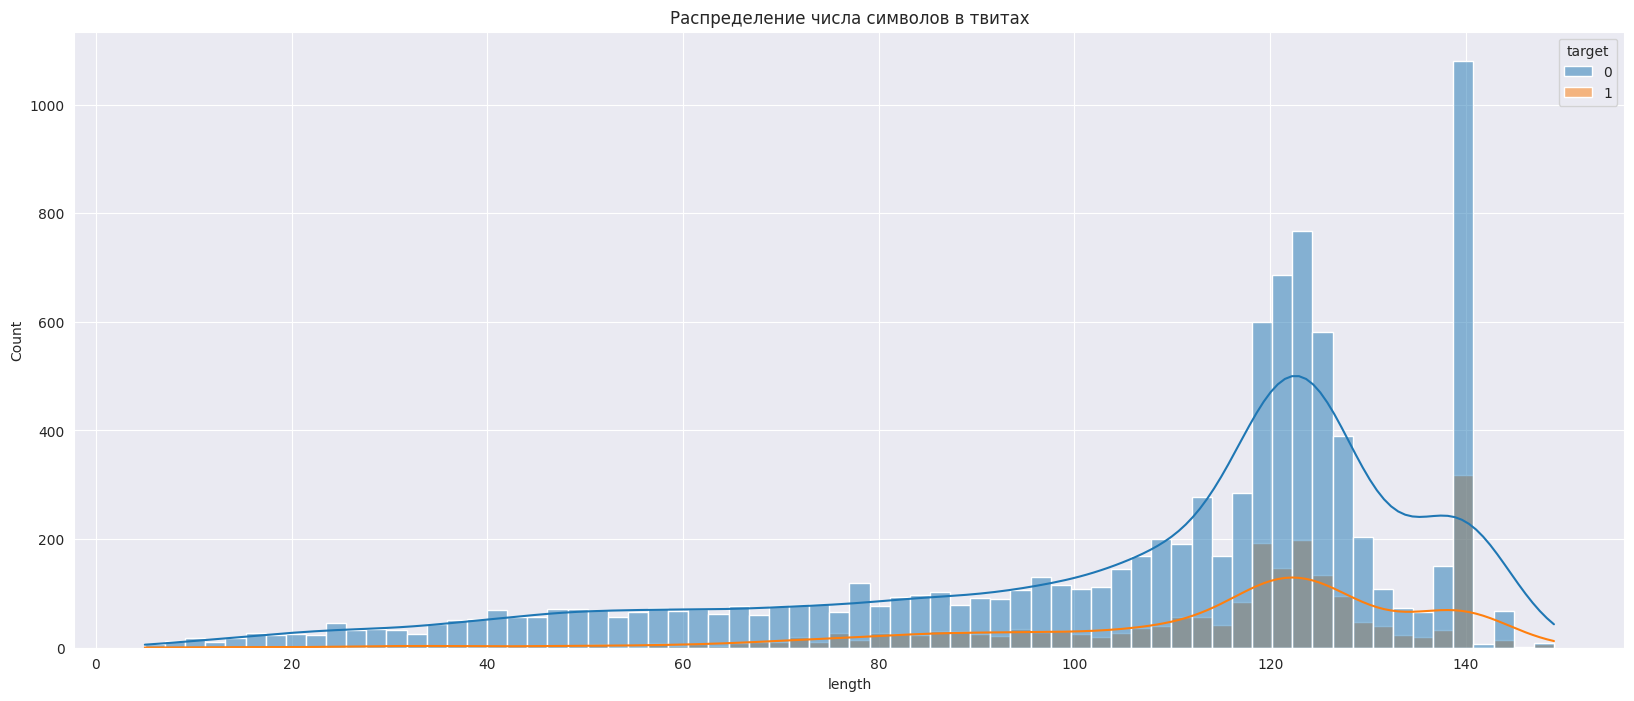

In [6]:
tweets['length'] = tweets.text.apply(len)

plt.figure(figsize=(20,8))
sns.histplot(data=tweets,x='length',hue='target',kde= True,bins=70)
plt.title('Распределение числа символов в твитах')
plt.show()

Распределение числа символом среди твитов-катастроф и обычных твитов схоже: распределение нормально в диапазоне 116 - 126 слов и имеет скачок при 140 словах.

In [7]:
def count_word_len(string):
    res = []

    for s in string:
        res.append(len(s))

    return res

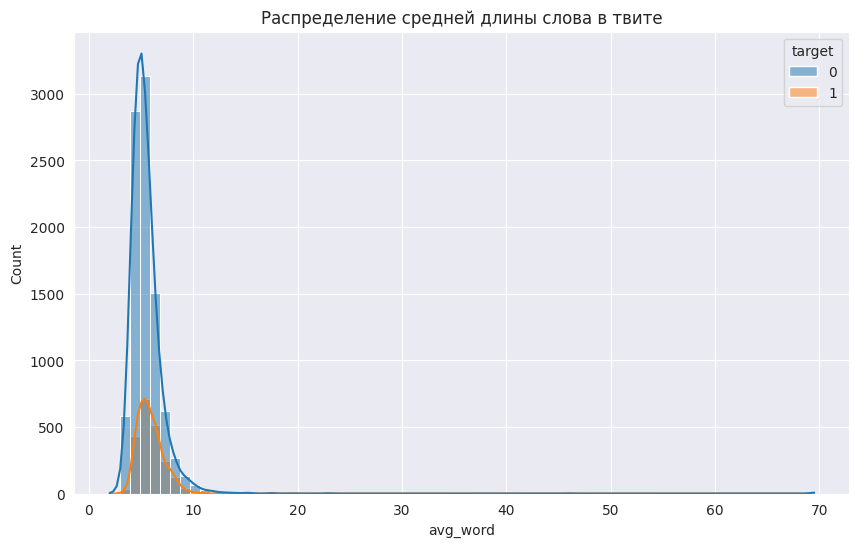

In [8]:
tweets['avg_word'] = tweets['text'].str.split().apply(count_word_len).map(lambda x: np.mean(x))

plt.figure(figsize=(10,6))
sns.histplot(tweets, x='avg_word', hue='target',kde= True,bins=70)
plt.title('Распределение средней длины слова в твите')
plt.show()

Распределение здесь так же одинаково, в основном длина слов находится в диапазоне от 3-10 символов в слове. Можно предположить, что длина слов в твитах не зависит от того, связана ли информация в нем с катастрофой или нет. Возможно, это связано с концепцией твиттера - делать небольшие заметки о происходящем.

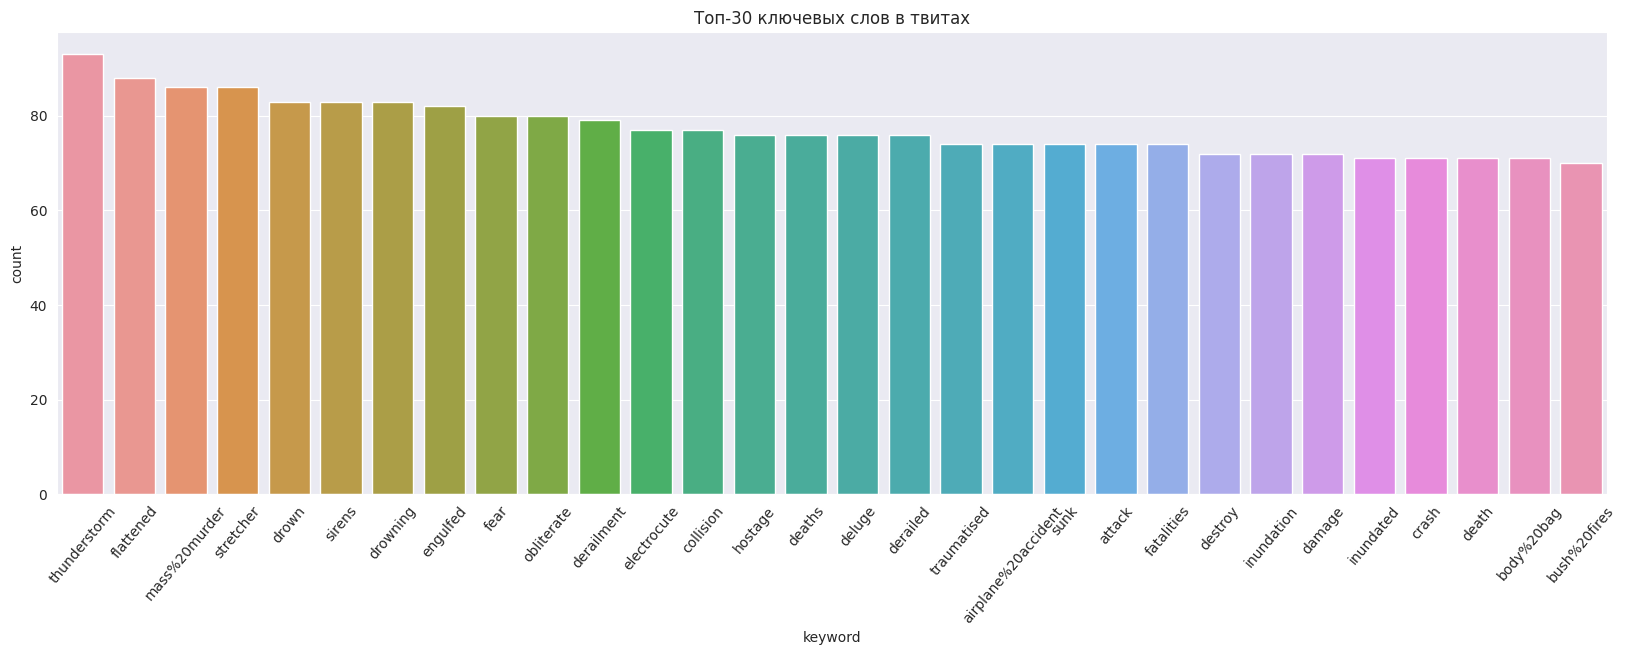

In [9]:
key_data = tweets.groupby('keyword')['target'].count().sort_values(ascending=False)
key_words = pd.DataFrame({'keyword': key_data.index, 'count': key_data.values})

plt.figure(figsize=(20,6))
sns.barplot(data=key_words.head(30), x='keyword', y='count')
plt.xticks(rotation = 50)
plt.title('Топ-30 ключевых слов в твитах')
plt.show()

Хоть число твитов-катастроф в 4 раза меньше числа обычных твитов, в топе ключевых слов в основном находятся те, которые так или иначе связаны с катаклизмами или трагедиями. Это можно объяснить тем, что в обычной жизни люди в основном пишут на сильно разбросанные темы, и такие твиты сложно объединить в большие группы.

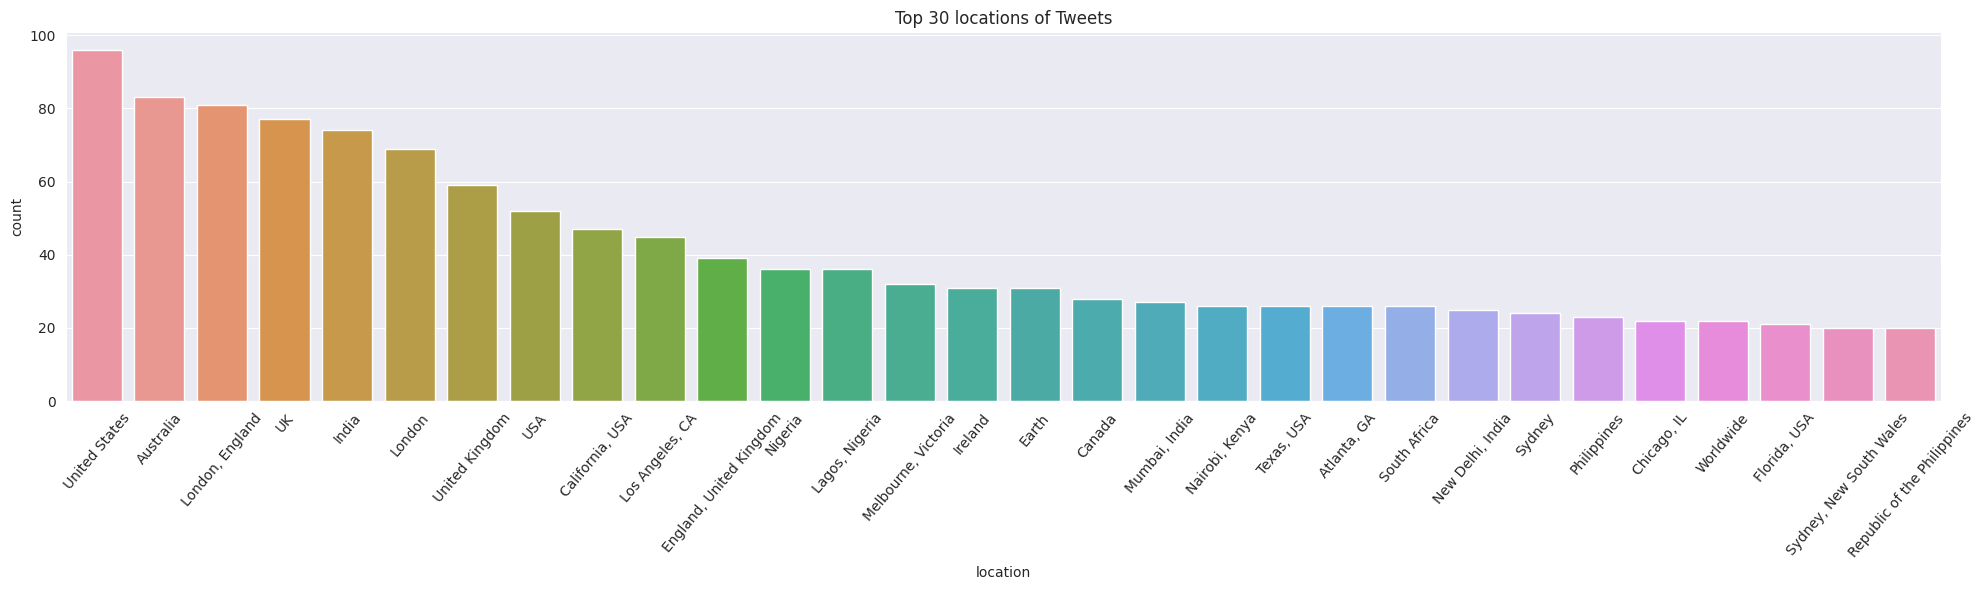

In [10]:
data_loc = tweets.groupby('location')['target'].count().sort_values(ascending=False)
locat = pd.DataFrame({'location': data_loc.index,'count': data_loc.values})

plt.figure(figsize=(20,6))
sns.barplot(data=locat.head(30),x='location',y='count')
plt.xticks(rotation = 50)
plt.title('Top 30 locations of Tweets')
plt.tight_layout()
plt.show()

### Удаление стоп-слов, пунктуации и всякого мусора

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import re

def remove_garbage(string):

    res = string.lower()
    res = " ".join([word for word in res.split() if word not in stopwords.words('english')])
    # удаление ссылок
    res = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ', res)
#     удаление html знаков
    res = re.sub(r'<.*?>',' ',res)

#     удаляю всякую нечисть
    res = re.sub(r"won\'t", " will not", res)
    res = re.sub(r"won\'t've", " will not have", res)
    res = re.sub(r"can\'t", " can not", res)
    res = re.sub(r"don\'t", " do not", res)
    res = re.sub(r"can\'t've", " can not have", res)
    res = re.sub(r"ma\'am", " madam", res)
    res = re.sub(r"let\'s", " let us", res)
    res = re.sub(r"ain\'t", " am not", res)
    res = re.sub(r"shan\'t", " shall not", res)
    res = re.sub(r"sha\n't", " shall not", res)
    res = re.sub(r"o\'clock", " of the clock", res)
    res = re.sub(r"y\'all", " you all", res)
    res = re.sub(r"n\'t", " not", res)
    res = re.sub(r"n\'t've", " not have", res)
    res = re.sub(r"\'re", " are", res)
    res = re.sub(r"\'s", " is", res)
    res = re.sub(r"\'d", " would", res)
    res = re.sub(r"\'d've", " would have", res)
    res = re.sub(r"\'ll", " will", res)
    res = re.sub(r"\'ll've", " will have", res)
    res = re.sub(r"\'t", " not", res)
    res = re.sub(r"\'ve", " have", res)
    res = re.sub(r"\'m", " am", res)
    res = re.sub(r"\'re", " are", res)

#     убираю числа
    res = re.sub(r'[0-9]', '', res)
#     удаляю всякие символы, которые перекодировались в текст типа эмоджи
    res = re.sub("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',res)

#     удаляю потеряшек из текста
    res = re.sub('[^a-zA-Z]',' ',res)
    res = re.sub(r"\([^()]*\)", "", res)

#     удаляю ответы
    res = re.sub('@\S+', '', res)

#     удаляю пунктуацию
    res = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', res)

    return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
tweets_clean = tweets.copy()

tweets_clean['text'] = tweets_clean['text'].apply(lambda x: remove_garbage(x))

#### Лемматизация и токенизация

In [17]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

def token(string):
    res = RegexpTokenizer(r'\w+').tokenize(string)
    return res

def lemmatize(string):
    lemm = WordNetLemmatizer()

    return ' '.join([lemm.lemmatize(word) for word in string])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
tweets_clean['tokens'] = tweets_clean['text'].map(token)
tweets_clean['lemmas'] = tweets_clean['tokens'].map(lemmatize)

#### Подготовка к ML части

In [20]:
train_X, val_X, train_y, val_y = train_test_split(tweets_clean['lemmas'],
                                                    tweets_clean['target'],
                                                    test_size=0.25,
                                                    random_state = 42)

train_X, test_X, train_y, test_y = train_test_split(train_X,
                                                    train_y,
                                                    test_size=0.3,
                                                    random_state = 42)

### Count based word embedding + SVC and GradientBoostingClassifier

In [32]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

cv = CountVectorizer()
svc = SVC(kernel='linear', degree=3, gamma='auto')

model_svc_cv = Pipeline([('vectorizer', cv), ('classifier', svc)])

model_svc_cv.fit(train_X, train_y)

print(classification_report(test_y, model_svc_cv.predict(test_X)))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2037
           1       0.69      0.61      0.65       522

    accuracy                           0.86      2559
   macro avg       0.79      0.77      0.78      2559
weighted avg       0.86      0.86      0.86      2559



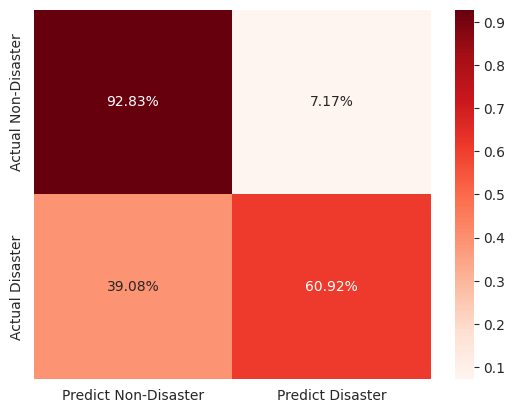

In [31]:
cm = pd.DataFrame(confusion_matrix(test_y, model_svc_cv.predict(test_X)))
cm.columns = ['Predict Non-Disaster', 'Predict Disaster']
cm.index = ['Actual Non-Disaster', 'Actual Disaster']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Reds', fmt='.2%')
plt.show()

Видно, что алгоритму было легче предсказывать не катастрофы, так как таких твитов больше.

In [35]:
grd = GradientBoostingClassifier()
model_grd_cv = Pipeline([('vectorizer', cv), ('classifier', grd)])

model_grd_cv.fit(train_X, train_y)

print(classification_report(test_y, model_grd_cv.predict(test_X)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2037
           1       0.90      0.17      0.29       522

    accuracy                           0.83      2559
   macro avg       0.86      0.58      0.60      2559
weighted avg       0.84      0.83      0.78      2559



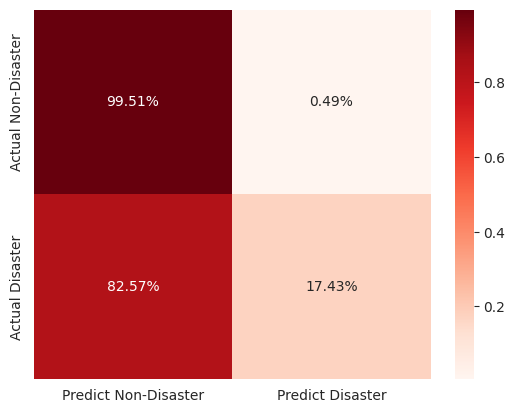

In [36]:
cm = pd.DataFrame(confusion_matrix(test_y, model_grd_cv.predict(test_X)))
cm.columns = ['Predict Non-Disaster', 'Predict Disaster']
cm.index = ['Actual Non-Disaster', 'Actual Disaster']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Reds', fmt='.2%')
plt.show()

Эта модель справилась хуже предыдущей, так как по результатам видно, что она просто большинству твитов приписывала то, что они не связаны с катастрофой, причина этому та же, что и у прошлой модели.

### Word2Vec + SVC and GradientBoostingClassifier

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec

class Word2VecVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, epochs=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.vector_size = vector_size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.epochs = epochs
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            vector_size=self.vector_size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, epochs=self.epochs, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.key_to_index]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.vector_size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.vector_size)

In [79]:
w2v = Word2VecVectorizer(vector_size=50, min_count=10, sg=1, alpha=0.025, epochs=10)

w2v.fit(train_X, train_y)

hyperparameters = {'C': [0.1, 1],
                   'gamma': [1, 0.1],
                   'kernel': ['rbf'],
                   'probability': [True]}

model_svc_w2v = Pipeline([('vectorizer', w2v), ('classifier', GridSearchCV(SVC(), hyperparameters,
                           refit=True, verbose=3))])

model_svc_w2v.fit([string.split() for string in train_X], train_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END C=0.1, gamma=1, kernel=rbf, probability=True;, score=0.837 total time=   2.4s
[CV 2/5] END C=0.1, gamma=1, kernel=rbf, probability=True;, score=0.840 total time=   2.4s
[CV 3/5] END C=0.1, gamma=1, kernel=rbf, probability=True;, score=0.833 total time=   3.5s
[CV 4/5] END C=0.1, gamma=1, kernel=rbf, probability=True;, score=0.838 total time=   2.4s
[CV 5/5] END C=0.1, gamma=1, kernel=rbf, probability=True;, score=0.835 total time=   2.4s
[CV 1/5] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.822 total time=   2.3s
[CV 2/5] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.821 total time=   2.3s
[CV 3/5] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.817 total time=   3.4s
[CV 4/5] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.821 total time=   2.3s
[CV 5/5] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.819 total time=   2.3s
[CV 1/5] END C=1, ga

Pipeline(steps=[('vectorizer',
                 Word2VecVectorizer(epochs=10, min_count=10, sg=1,
                                    vector_size=50)),
                ('classifier',
                 GridSearchCV(estimator=SVC(),
                              param_grid={'C': [0.1, 1], 'gamma': [1, 0.1],
                                          'kernel': ['rbf'],
                                          'probability': [True]},
                              verbose=3))])

In [80]:
model_svc_w2v_best = Pipeline([('vectorizer', w2v), ('classifier', SVC(C=1, gamma=1, kernel='rbf', probability=True))])

model_svc_w2v_best.fit(train_X, train_y)

print(classification_report(test_y, model_svc_w2v_best.predict(test_X)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2037
           1       0.00      0.00      0.00       522

    accuracy                           0.80      2559
   macro avg       0.40      0.50      0.44      2559
weighted avg       0.63      0.80      0.71      2559



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ну в общем что-то пошло не так, и модель здесь совсем плохая (потому что f1-score = 1) получилась. Скорее всего, параметры для Word2Vec тоже нужно подбирать, тогда качество всей модели улучшиться.

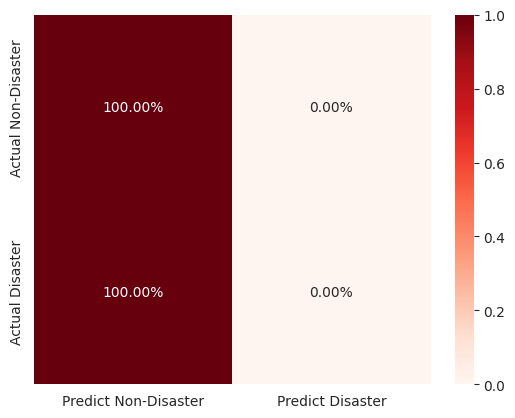

In [81]:
cm = pd.DataFrame(confusion_matrix(test_y, model_svc_w2v_best.predict(test_X)))
cm.columns = ['Predict Non-Disaster', 'Predict Disaster']
cm.index = ['Actual Non-Disaster', 'Actual Disaster']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Reds', fmt='.2%')
plt.show()

Ну в целом тут все просто в один класс ушли. Поэтому accuracy = 0.8, потому что твитов нон-катастроф - 80% от общего датасета.

In [82]:
model_grd_w2v = Pipeline(steps = [('vectorizer', w2v), ('GradientBoosting', grd)])

model_grd_w2v.fit(train_X, train_y)

print(classification_report(test_y, model_grd_w2v.predict(test_X)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2037
           1       0.84      0.04      0.08       522

    accuracy                           0.80      2559
   macro avg       0.82      0.52      0.48      2559
weighted avg       0.81      0.80      0.72      2559



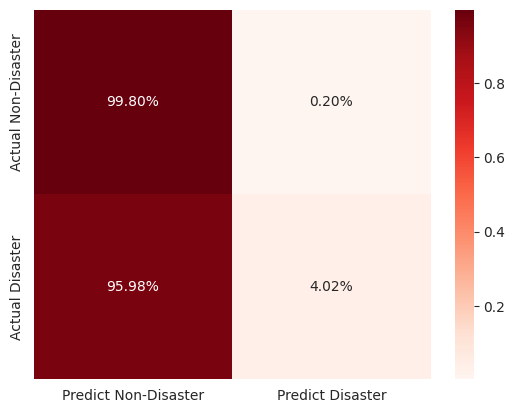

In [83]:
cm = pd.DataFrame(confusion_matrix(test_y, model_grd_w2v.predict(test_X)))
cm.columns = ['Predict Non-Disaster', 'Predict Disaster']
cm.index = ['Actual Non-Disaster', 'Actual Disaster']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Reds', fmt='.2%')
plt.show()

Здесь модель хотя бы немножко подумала, а не просто все пихала в один класс, но результат конечно плохой. Учитывая, что эмеддинг еще и тренируется на данных, то можно сделать такой вывод: нужно подбирать гиперпараметры для эмеддинга в том числе.

### Нейронка (BERT)

Я решила взять эту, потому что хоть в каком-то пункте хочу увидеть хороший результат предсказаний

In [84]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import transformers
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,
                'targets': target
            }

In [ ]:
vocab_max_size = len(set(all_clear_train))

max_sentence = np.max([len(i) for i in all_clear_train])

print(f'Vocab_size: {vocab_max_size}')
print(f'Maximum_Sentence_length: {max_sentence}')

Vocab_size: 706
Maximum_Sentence_length: 272


In [ ]:
voc_size = 5000  # after some itreations I got this voc_size (becaue it gives more accuracy)
# Before giving word embedding, we need to convert our text to index with certain padding, let's do that
one_hot_train = [one_hot(words, voc_size)for words in all_clear_train]
one_hot_test = [one_hot(words, voc_size)for words in all_clear_test]

max_sent_length = 30

pad_train = pad_sequences(one_hot_train, padding = 'pre', maxlen = max_sent_length)
pad_test = pad_sequences(one_hot_test, padding = 'pre', maxlen = max_sent_length)

In [ ]:
print(len(pad_train))
print(len(pad_test))

print(pad_train.shape)
print(pad_test.shape)

717
240
(717, 30)
(240, 30)


In [ ]:
embedding_vector_features = 100
model = Sequential()

model.add(Embedding(voc_size, embedding_vector_features, input_length = max_sent_length))
model.add(Dropout(0.5))
model.add(LSTM(200))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))  # тк бинарная классификация
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics = tf.keras.metrics.BinaryAccuracy())


In [ ]:
train_x_ = np.array(pad_train)
test_x_ = np.array(pad_test)

train_y_ = np.array(train_y)
test_y_ = np.array(test_y)

In [ ]:
history =  model.fit(train_x_, train_y_, validation_data = (test_x_, test_y_), epochs =100, batch_size = 64)

Epoch 1/100
12/12 [==============================] - 6s 251ms/step - loss: 0.5029 - binary_accuracy: 0.8410 - val_loss: 0.3635 - val_binary_accuracy: 0.8667
Epoch 2/100
12/12 [==============================] - 1s 124ms/step - loss: 0.3259 - binary_accuracy: 0.8745 - val_loss: 0.3366 - val_binary_accuracy: 0.8750
Epoch 3/100
12/12 [==============================] - 1s 124ms/step - loss: 0.2353 - binary_accuracy: 0.8898 - val_loss: 0.1899 - val_binary_accuracy: 0.9375
Epoch 4/100
12/12 [==============================] - 1s 125ms/step - loss: 0.1335 - binary_accuracy: 0.9707 - val_loss: 0.2198 - val_binary_accuracy: 0.9208
Epoch 5/100
12/12 [==============================] - 2s 134ms/step - loss: 0.0871 - binary_accuracy: 0.9763 - val_loss: 0.1034 - val_binary_accuracy: 0.9750
Epoch 6/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0365 - binary_accuracy: 0.9902 - val_loss: 0.0820 - val_binary_accuracy: 0.9708
Epoch 7/100
12/12 [==============================] - 2s 14

In [ ]:
model.weights

[<tf.Variable 'embedding_4/embeddings:0' shape=(5000, 100) dtype=float32, numpy=
 array([[ 0.02330423,  0.04216745,  0.02915678, ...,  0.0016014 ,
         -0.05275943, -0.00547134],
        [ 0.0303799 , -0.02706586, -0.0252496 , ...,  0.04209152,
         -0.03435602, -0.04310016],
        [-0.0100461 ,  0.00908052, -0.03286864, ..., -0.05721423,
          0.01704993,  0.00628574],
        ...,
        [-0.07619043,  0.01022038, -0.06588311, ...,  0.01207963,
         -0.06516654,  0.00694592],
        [-0.04005288, -0.01336569, -0.01681327, ..., -0.00404292,
         -0.03565477,  0.01742423],
        [-0.00963659,  0.02810666, -0.02463738, ...,  0.00621191,
          0.04047828, -0.02805419]], dtype=float32)>,
 <tf.Variable 'lstm_4/lstm_cell/kernel:0' shape=(100, 800) dtype=float32, numpy=
 array([[ 0.02791454,  0.02138791,  0.00486183, ...,  0.04118043,
          0.05190789, -0.09990557],
        [-0.04215526,  0.06561745, -0.01993521, ...,  0.03050281,
         -0.00855319, -0.03

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.502874,0.841004,0.363545,0.866667
1,0.325888,0.874477,0.336570,0.875000
2,0.235344,0.889819,0.189879,0.937500
3,0.133545,0.970711,0.219825,0.920833
4,0.087101,0.976290,0.103441,0.975000
...,...,...,...,...
95,0.000007,1.000000,0.211513,0.975000
96,0.000014,1.000000,0.210061,0.979167
97,0.000012,1.000000,0.210886,0.979167
98,0.000005,1.000000,0.211415,0.979167


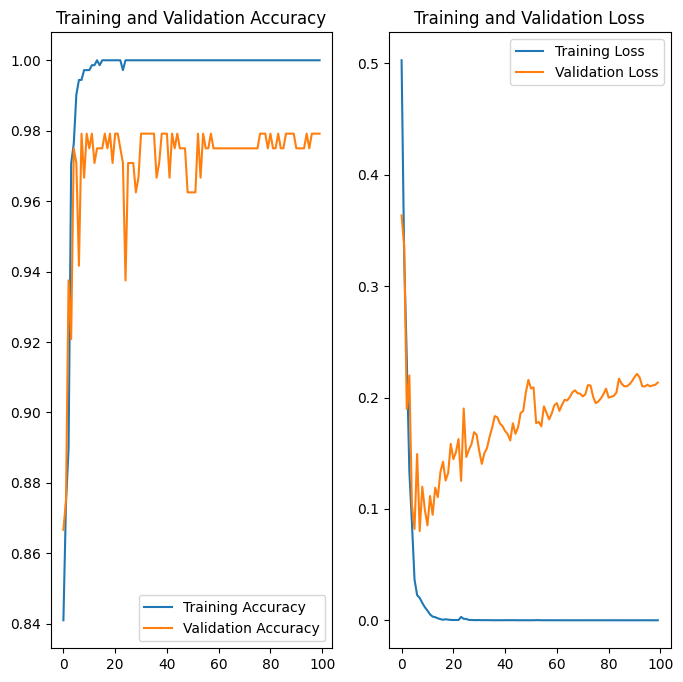

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction

In [ ]:
# data_labels = train_clear['Label']
# data_tweets = train_clear['lemmas']

# data_labels = data_labels.replace(['Spam'], 1)
# data_labels = data_labels.replace(['Non-Spam'], 0)

# train_X, test_X, train_y, test_y = train_test_split(data_tweets,
#                                                     data_labels,
#                                                     test_size=0.25,
#                                                     random_state = 42)

# val_y = test_clear['Label']
# val_X = test_clear['lemmas']

# val_y = val_y.replace(['Spam'], 1)
# val_y = val_y.replace(['Non-Spam'], 0)

In [ ]:
all_clear_val = []
for text in val_X:
    all_clear_val.append(text)

In [ ]:
voc_size = 5000  # after some itreations I got this voc_size (becaue it gives more accuracy)
# Before giving word embedding, we need to convert our text to index with certain padding, let's do that
# one_hot_train = [one_hot(words, voc_size)for words in all_clear_train]
one_hot_val = [one_hot(words, voc_size)for words in all_clear_val]

max_sent_length = 30

# pad_train = pad_sequences(one_hot_train, padding = 'pre', maxlen = max_sent_length)
pad_val = pad_sequences(one_hot_val, padding = 'pre', maxlen = max_sent_length)

In [ ]:
print(len(pad_val))
print(pad_val.shape)

125
(125, 30)


In [ ]:
val_x_ = np.array(pad_val)
val_y_ = np.array(val_y)

In [ ]:
val_y.value_counts()

1    76
0    49
Name: Label, dtype: int64

In [ ]:
predictions = model.predict(pad_val)

4/4 [==============================] - 1s 51ms/step


In [ ]:
testing_labels = pd.DataFrame(val_y_)
testing_labels = testing_labels.rename(columns={0 : 'Label'})
testing_labels['Prediction'] = predictions
testing_labels

,Label,Prediction
0,1,9.999936e-01
1,1,1.977340e-02
2,1,9.999926e-01
3,1,9.999971e-01
4,1,9.999719e-01
...,...,...
120,0,1.782290e-07
121,0,5.004498e-07
122,0,4.983029e-07
123,0,5.291694e-07


<Axes: xlabel='Prediction', ylabel='Count'>

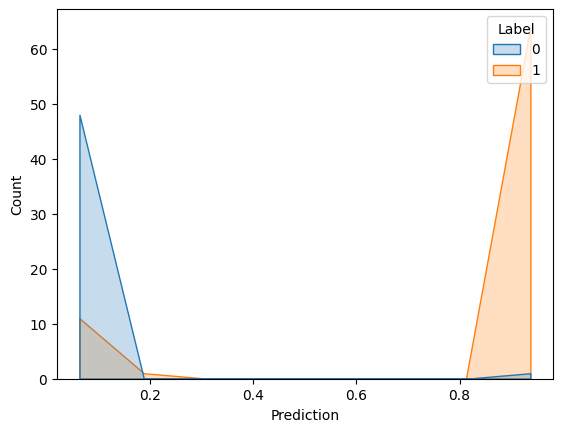

In [ ]:
sns.histplot(testing_labels, x='Prediction', hue='Label', element='poly')

In [ ]:
testing_labels['Prediction_labels'] = (testing_labels['Prediction'] > 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(testing_labels['Label'], testing_labels['Prediction_labels'])

print('Accuracy: {}'.format(accuracy))
print(classification_report(testing_labels['Label'], testing_labels['Prediction_labels']))

Accuracy: 0.896
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        49
           1       0.98      0.84      0.91        76

    accuracy                           0.90       125
   macro avg       0.89      0.91      0.89       125
weighted avg       0.91      0.90      0.90       125



<Axes: >

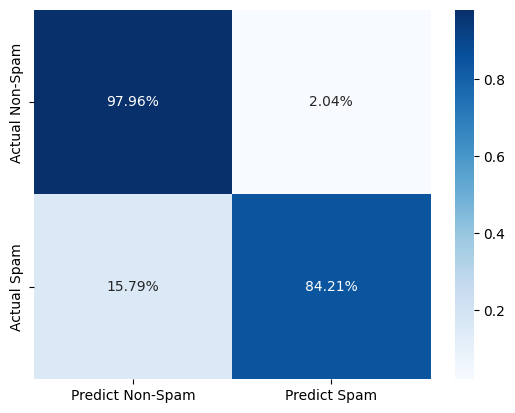

In [ ]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(testing_labels['Label'], testing_labels['Prediction_labels']))
cm.columns = ['Predict Non-Spam', 'Predict Spam']
cm.index = ['Actual Non-Spam', 'Actual Spam']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2%')